In [3]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
import seaborn as sns

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

In [4]:
from sklearn.datasets import load_iris
from sklearn import datasets

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

## 피마 인디언 당뇨병 예측
- 데이터세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임
- 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생

#### 과제(3): diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

In [87]:
db_data = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\diabetes.csv')

print(db_data['Outcome'].value_counts())
# 768개의 데이터중 Negative값(0)이 500개, Positive값(1)이 268개

db_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [88]:
db_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [89]:
db_data.describe()
# min값이 0인 칼럼들이 많음
# Glucose(포도당), BloodPressure(혈압), SkinThickness(팔 피하지방), Insulin(인슐린), BMI(체질량 지수)
# 와 같은 칼럼들은 0일 수가 없음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [90]:
# 0수치를 검사할 칼럼(피처) 리스트 -> 값이 0일리가 없는 칼럼들
# Pregnancies는 출산횟수여서 제외(충분히 값이 0일 수 있음)
zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터
total_count = db_data['Glucose'].count()

# 각 칼럼의 데이터값이 0인 건수 추출, 퍼센트 계산
for i in zero:
    zero_count = db_data[db_data[i]==0][i].count()
    print(f'{i} 칼럼의 0 건수는 {zero_count}, 퍼센트는 {(zero_count/total_count*100):0.4f}')

Glucose 칼럼의 0 건수는 5, 퍼센트는 0.6510
BloodPressure 칼럼의 0 건수는 35, 퍼센트는 4.5573
SkinThickness 칼럼의 0 건수는 227, 퍼센트는 29.5573
Insulin 칼럼의 0 건수는 374, 퍼센트는 48.6979
BMI 칼럼의 0 건수는 11, 퍼센트는 1.4323


In [91]:
# 위 칼럼들의 0값을 평균값으로 대체
# (참고할 데이터가 있다면 무조건 평균으로 하지 않는 것이 좋음)
db_data[zero] = db_data[zero].replace(0, db_data[zero].mean())

# 확인
for i in zero:
    zero_count = db_data[db_data[i]==0][i].count()
    print(f'{i} 칼럼의 0 건수는 {zero_count}, 퍼센트는 {(zero_count/total_count*100):0.4f}')

Glucose 칼럼의 0 건수는 0, 퍼센트는 0.0000
BloodPressure 칼럼의 0 건수는 0, 퍼센트는 0.0000
SkinThickness 칼럼의 0 건수는 0, 퍼센트는 0.0000
Insulin 칼럼의 0 건수는 0, 퍼센트는 0.0000
BMI 칼럼의 0 건수는 0, 퍼센트는 0.0000


In [92]:
db_data.info( )
# null값 없고, 피처(칼럼) 타입은 모두 숫자형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [99]:
### 사용자 함수(모델성능 평가 지표 확인) ###

def get_clf_eval(y_test=None, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    # (TN) (FP)  혼동행렬 분류 결과 순서
    # (FN) (TP)
    
    accuracy = accuracy_score(y_test, pred)   #정확도((TP+TN) / (TP+TN+FP+FN))
    precision = precision_score(y_test, pred)   #정밀도(TP / (TP+FP)):
    recall = recall_score(y_test, pred)   #재현율(TP / (TP+FN)):
    f1 = f1_score (y_test, pred)   #f1 score(2 * (정밀도*재현율) / (정밀도+재현율))
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print(f'오차 행렬\n{confusion}\n')
    print(f'''정확도: {accuracy:.4f}, 
정밀도 : {precision:.4f}, 
재현율 : {recall:.4f}, 
f1 score: {f1:.4f}
roc_auc: {roc_auc:.4f}''')

- 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 하는 것이 좋음
- 이후 학습/테스트 셋으로 나눠 로지스틱 회귀 적용, 성능평가 지표 확인

In [100]:
from sklearn.linear_model import LogisticRegression
ydf = db_data['Outcome']
xdf = db_data.drop('Outcome', axis=1)

# 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 하는 것이 좋음
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xdf = scaler.fit_transform(xdf)

# 이후 학습/테스트 셋으로 나눠 로지스틱 회귀 적용, 성능평가 지표 확인
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, random_state=231)
lgr = LogisticRegression()
lgr.fit(x_train, y_train)

pred = lgr.predict(x_test)    #negative(발병), positive(발병x)에 대한 확률
pred_proba = lgr.predict_proba(x_test)[:,1]   #발병x에 대한 예측 확률
                       
get_clf_eval(y_test, pred, pred_proba)   #위 함수 호출

오차 행렬
[[86 17]
 [22 29]]

정확도: 0.7468, 
정밀도 : 0.6304, 
재현율 : 0.5686, 
f1 score: 0.5979
roc_auc: 0.8296


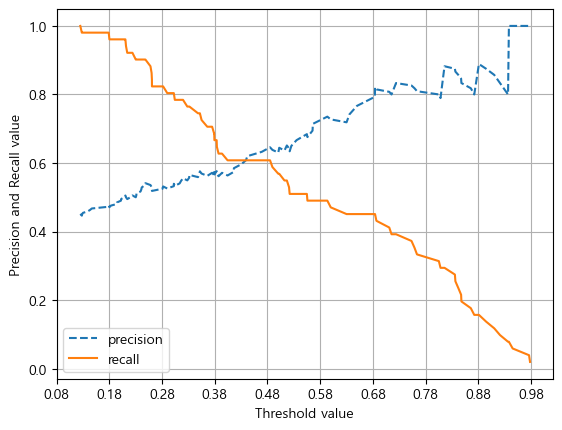

In [95]:
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화

def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # 임계값에 따른 정밀도 재현율 배열 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    threshold_boundary = thresholds.shape[0]
    
    # x축을 임계값으로, y축은 정밀도와 재현율 값으로 그래프 기리기
    plt.plot(thresholds, precisions[0: threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0: threshold_boundary], label='recall')
    
    # 임계값 x축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축, label, legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

pred_proba_class1 = lgr.predict_proba(x_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_class1)

#### 과제(4): 피마 당뇨병 데이터셋으로 다음을 수행하세요
- 예측모델 생성: 로지스틱 회귀 적용 및 분류 평가
- precision_recall_curve를 시각화
- 재현율에 비중을 좀 더 부여하는 것이 필요한 상황을 전제로 적절한 임계값 구하기 (임계값 0.2~0.3 정도가 적당할 거라고 생각)

In [96]:
db_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [97]:
ydf = db_data['Outcome']
xdf = db_data.drop('Outcome', axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, 
                test_size=0.2, random_state=324, stratify=ydf)
#stratify: 훈련/테스트 데이터들의 클래스 비율이 원본과 같도록 지정

lg = LogisticRegression()
lg.fit(xtrain, ytrain)

pred = lg.predict(xtest)
pred_proba = lg.predict_proba(xtest)
####################################################
confusion = confusion_matrix(ytest, pred)
acc = accuracy_score(ytest, pred)
precision = precision_score(ytest, pred)
recall = recall_score(ytest, pred)
f1 = f1_score(ytest, pred)

roc_auc = roc_auc_score(ytest, pred_proba[:, 1])

print(f'오차행렬:\n{confusion}\n')
print(f'정확도: {acc}')
print(f'정밀도: {precision}')
print(f'재현율: {recall}')
print(f'f1_score: {f1}')
print(f'roc_auc: {roc_auc}')

오차행렬:
[[88 12]
 [30 24]]

정확도: 0.7272727272727273
정밀도: 0.6666666666666666
재현율: 0.4444444444444444
f1_score: 0.5333333333333333
roc_auc: 0.7868518518518518


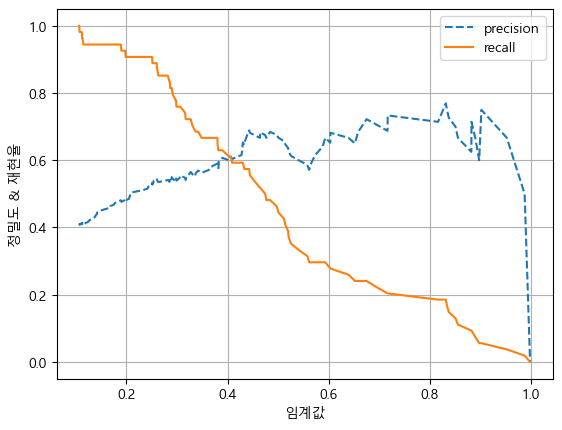

In [98]:
from sklearn.metrics import precision_recall_curve
pred_proba_c = pred_proba[:,1]
precision, recalls, thresholds = precision_recall_curve(ytest, pred_proba_c)

thr_index = np.arange(0, thresholds.shape[0], 1)
plt.plot(thresholds[thr_index], precision[thr_index], linestyle='--', label='precision')
plt.plot(thresholds[thr_index], recalls[thr_index], label='recall')

plt.xlabel('임계값'); plt.ylabel('정밀도 & 재현율')
plt.legend(); plt.grid()
plt.show()

### 강사님 코드

In [72]:
diabetes_data = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\diabetes.csv')

print(diabetes_data['Outcome'].value_counts())
# 768개의 데이터중 Negative값(0)이 500개, Positive값(1)이 268개

diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [73]:
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [74]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [75]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,    F1: 0.6465, AUC:0.8083


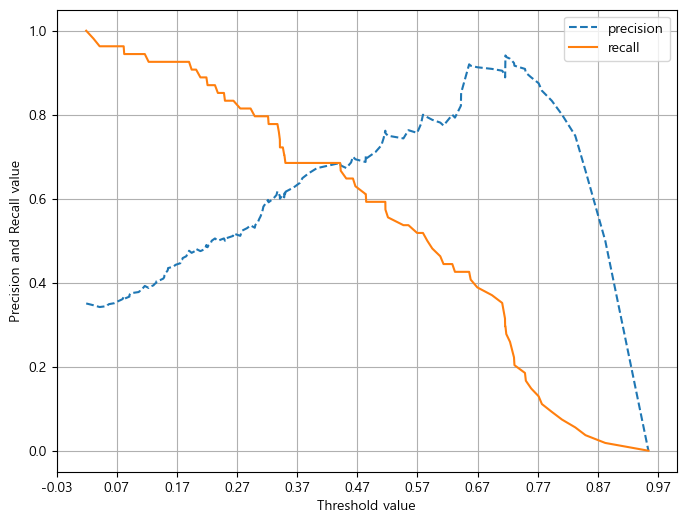

In [76]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [77]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


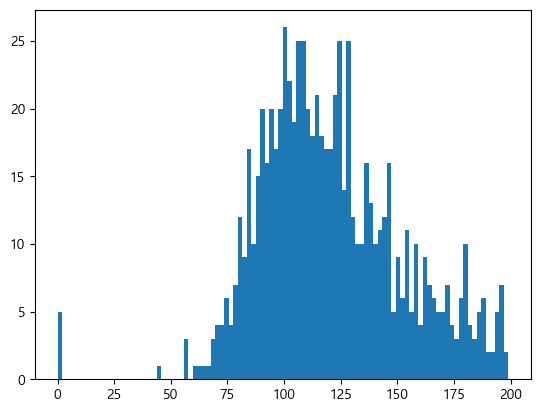

In [78]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [79]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))


Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [80]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [81]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


In [83]:
### 임계값에 따른 평가 수치 출력 함수
from sklearn.preprocessing import Binarizer
pred_proba_c1 = pred_proba.reshape(-1,1)

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [84]:
# 임계값을 0.3~0.5 변화시키며 평가지표 확인
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,    F1: 0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


In [85]:
#재현율을 약간 올리면서 전체적인 성능 평가 지표를 올리는 임계값: 0.48
get_eval_by_threshold(y_test, pred_proba_c1, [0.33, 0.48])

임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433


In [86]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
